In [1]:
import numpy as np
import seaborn as sns
import scipy.io as sio
import pandas as pd

from math import ceil, log
from random import randint
from scipy.stats import ranksums, bartlett, describe
from scipy.signal import welch
from scipy.fftpack import rfft
from matplotlib import pyplot as plt
from scipy.interpolate import interp1d


plt.rcParams['figure.figsize'] = (10, 6)

### Tomamos un epoch del electrodo 8 de una persona y calculamos welch

In [2]:
s1 = sio.loadmat('dataset/S01.mat')
array  = s1['data'] # una matriz tridimensional: trials/epochs x electrodos x muestras en Epoch

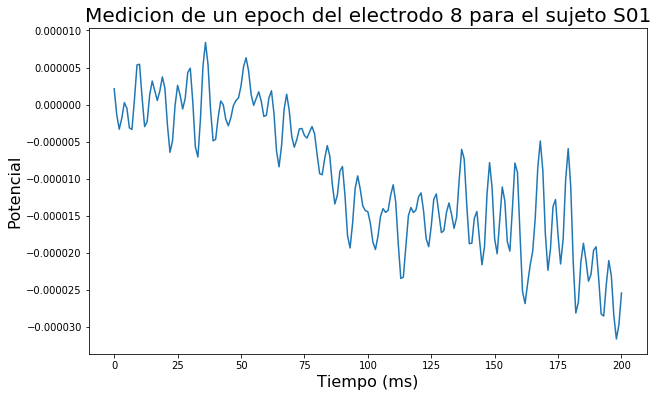

In [3]:
muestras8= array[:,8][0]
muestras8
plt.plot(muestras8)
plt.xlabel("Tiempo (ms)", fontsize=16)
plt.ylabel("Potencial", fontsize=16)
plt.title("Medicion de un epoch del electrodo 8 para el sujeto S01", fontsize=20)
plt.show()

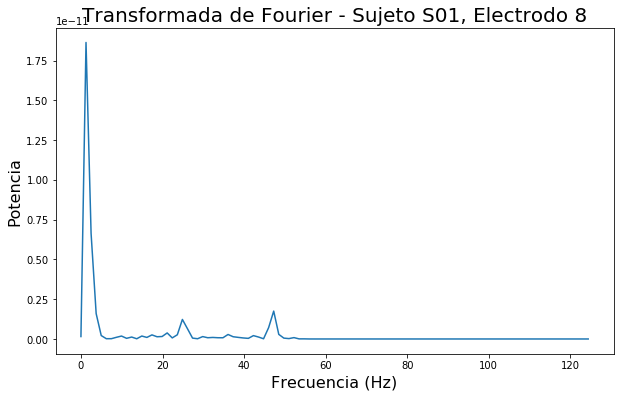

In [4]:
ff= welch(muestras8, fs=250, nperseg=201)
plt.plot(ff[0],ff[1])
plt.xlabel("Frecuencia (Hz)", fontsize=16)
plt.ylabel("Potencia", fontsize=16)
plt.title("Transformada de Fourier - Sujeto S01, Electrodo 8", fontsize=20)
plt.show()


### Comparamos los graficos de las frecuencias con picos con la medicion del electrodo

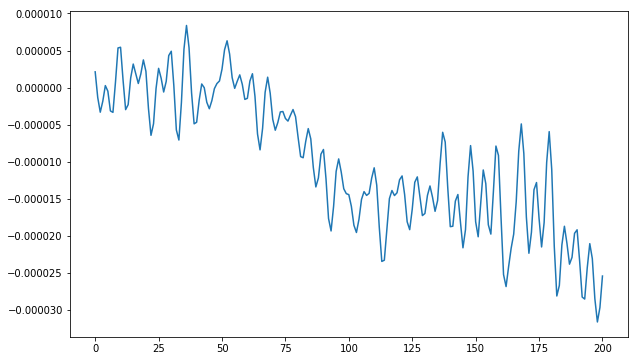

In [5]:
#Esto yo lo volaria, no nos salio hacerlo

omega = ff[0][31]
plt.plot(muestras8)
# plt.plot([np.sin(x*ff[0][1]) for x in range(0,201)])
# plt.plot([0.000010*np.sin(x/omega) for x in range(0,201)])
plt.show()

### Intentamos promediando los epochs para un electrodo

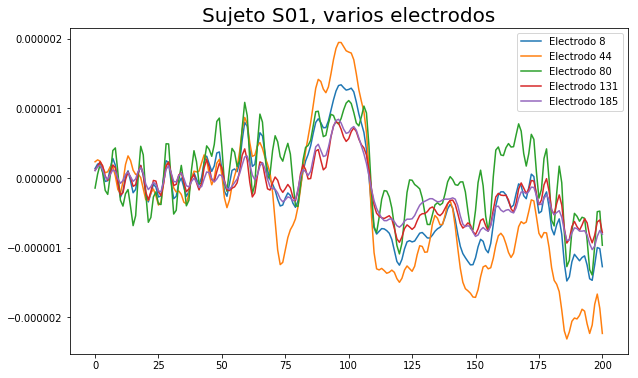

In [6]:
for i in [8,44,80, 131,185]:
    muestras= array[:,i].mean(axis=0)
    plt.plot(muestras, label="Electrodo {}".format(i))
plt.title("Sujeto S01, varios electrodos", fontsize=20)
plt.legend(loc='best')
plt.show()

In [7]:
electrodos = [8,44,80, 131,185]
muestras = np.array([0]*201)
for i in electrodos:
    muestras = np.add(muestras,array[:,i])
muestras = muestras/len(electrodos)
# muestras= array[:,8]
fouriers = []
matriz = []
for i in range(len(muestras)):
     freqs, pot = welch(muestras[i], fs=250, nperseg=201)
     matriz.append(pot)
npmatriz = np.array(matriz)

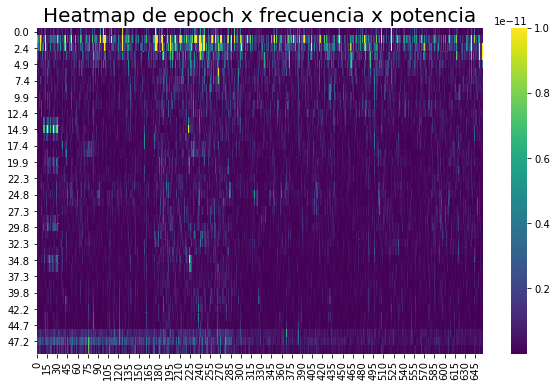

In [8]:
ax = sns.heatmap(npmatriz.transpose()[0:40], cmap="viridis", vmax=1e-11)
freqs = [freq for freq in freqs if freq<50]
freqs = [int(freq*10)/10.0 for freq in freqs]
freqs = [freqs[i] for i in range(len(freqs)) if i%2==0]
ax.set_yticklabels(freqs, rotation='horizontal')
plt.title("Heatmap de epoch x frecuencia x potencia", fontsize=20)
plt.show()

In [9]:
filenamesP = ['dataset/P0'+str(i)+'.mat' for i in range(1,10)]+['dataset/P10.mat']
filenamesS = ['dataset/S0'+str(i)+'.mat' for i in range(1,10)]+['dataset/S10.mat']
bandas = ['delta', 'epsilon', 'alfa', 'beta', 'gamma']

In [10]:
def FrecuenciasPorTipo(archivos, grupo):
    freqPotXPersona = []
    for filename in archivos:
        array = sio.loadmat(filename)['data']
        ffs = []
        for i in range(256):
            muestras= array[:,i][0]
            ff= welch(muestras, fs=250, nperseg=201)
            ffs.append(ff[1])
        frecuencia = ff[0]
        arrayffs = np.array(ffs)
        freqPotXPersona.append((frecuencia,arrayffs.mean(axis=0)))
    for index, freqPot in enumerate(freqPotXPersona):
        plt.plot(freqPot[0],freqPot[1], label=grupo+str(index+1))
    plt.legend(loc='best')
    plt.xlim(0,50)
    plt.show()
    
    return freqPotXPersona

def PromedioBandas(freqPotXPersona):
    proms = []#
    for j in range(len(freqPotXPersona)):
        proms.append([])
        freqPot = freqPotXPersona[j]
        buckets = [0,0,0,0,0]
        count = [0,0,0,0,0]
    
        for i in range(len(freqPot[1])):
            if freqPot[0][i] < 4:
                buckets[0] += freqPot[1][i]
                count[0] +=1
            elif freqPot[0][i] < 8:
                buckets[1] += freqPot[1][i]
                count[1] +=1
            elif freqPot[0][i] < 13:
                buckets[2] += freqPot[1][i]
                count[2] +=1
            elif freqPot[0][i] < 30:
                buckets[3] += freqPot[1][i]
                count[3] +=1
            else:
                buckets[4] += freqPot[1][i]
                count[4] +=1

        
        for i in range(len(buckets)):
            proms[j].append(buckets[i]/count[i])
    
    return proms
    

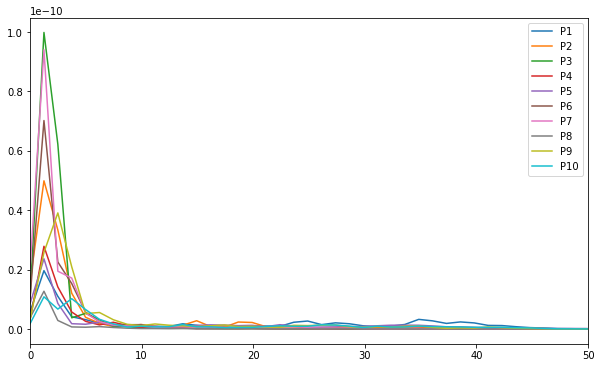

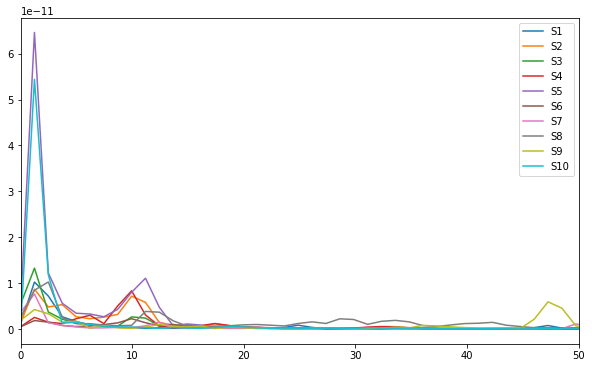

In [11]:
frecuenciasP = FrecuenciasPorTipo(filenamesP,'P') #FrecuenciasPorTipo plotea
frecuenciasS = FrecuenciasPorTipo(filenamesS, 'S')

bandasP = PromedioBandas(frecuenciasP)
bandasS = PromedioBandas(frecuenciasS)

In [12]:
tablaP = pd.DataFrame(bandasP, columns=bandas, index=['P'+str(i) for i in range(1,11)])
tablaS = pd.DataFrame(bandasS, columns=bandas, index=['S'+str(i) for i in range(1,11)])
tablaP['Tipo'] = 'P'
tablaS['Tipo'] = 'S'

todos = pd.concat([tablaP, tablaS])
todos[['alfa', 'Tipo']]

,alfa,Tipo
P1,8.597311e-13,P
P2,9.486518e-13,P
P3,4.638416e-13,P
P4,6.338850e-13,P
P5,9.192861e-13,P
P6,9.813531e-13,P
P7,8.245702e-13,P
P8,1.586481e-13,P
P9,1.409964e-12,P
P10,7.654888e-13,P


### Distribución de las distintas bandas de frecuencia para los dos grupos de sujetos

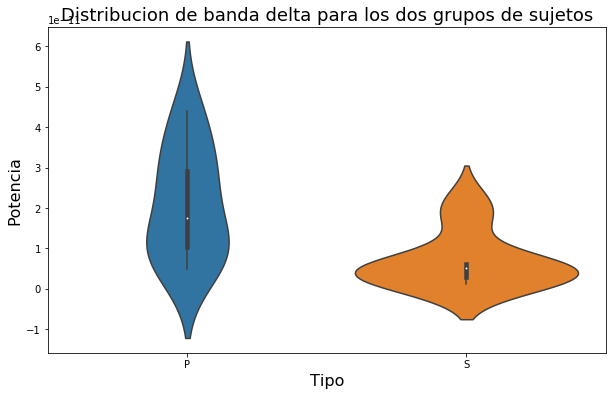

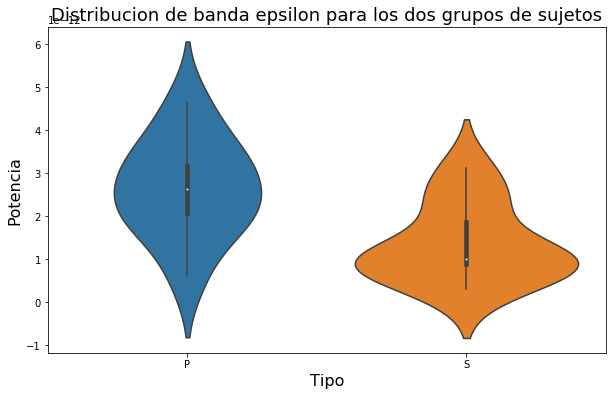

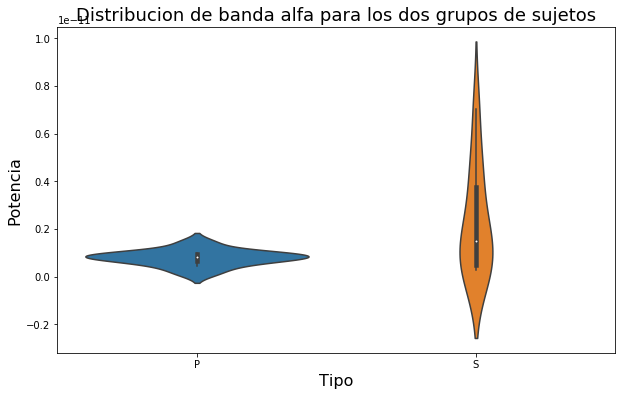

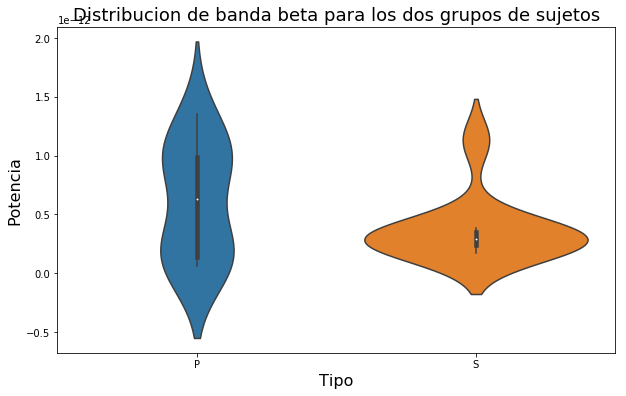

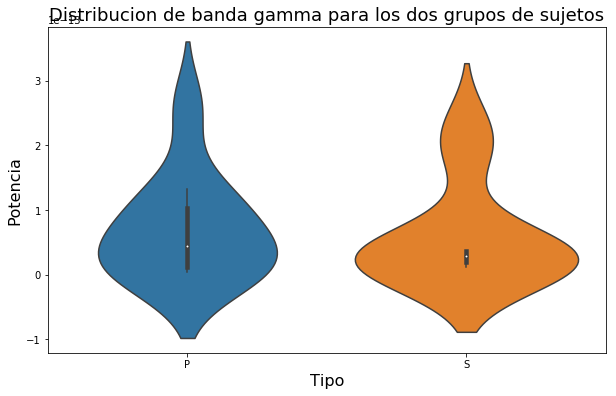

In [13]:
for banda in bandas:
    sns.violinplot(y=todos[banda], x=todos['Tipo'])
    plt.xlabel("Tipo", fontsize=16)
    plt.ylabel("Potencia", fontsize=16)
    plt.title("Distribucion de banda {} para los dos grupos de sujetos".format(banda), fontsize=18)
    plt.show()

#### Tests Estadisticos de las distribuciones de las bandas de frecuencia
1 - Realizaremos un Wilcoxon rank-sum test entre los dos grupos de sujetos, para cada banda de frecuencias. 

In [14]:
for banda in bandas:
    print banda,'tiene p-value: ', ranksums(tablaP[banda], tablaS[banda]).pvalue

delta tiene p-value:  0.00650170237308
epsilon tiene p-value:  0.0342937210365
alfa tiene p-value:  0.256839257958
beta tiene p-value:  0.705456986111
gamma tiene p-value:  0.879829160012


A partir del test podemos afirmar con alto grado de probabilidad que las medias de las bandas delta y epsilon son distintas para los pacientes de los distintos grupos. Ademas, a partir de los graficos podemos inferir que en ambas bandas la media del grupo P es mayor que la del grupo S.

Por otro lado, no podemos afirmar que las alfa, beta y gamma para ambos grupos tienen distinta distribucion.

2 - En el grafico de la distribucion de la banda alfa se observa claramente que la varianza del grupo S es mucho mayor que para el grupo P. Es por esto que realizaremos el tests de barlett, que tiene como hipotesis nula que las muestras provienen de distribuciones con igual varianza.

In [15]:
for banda in bandas:
    print banda,'tiene p-value: ', bartlett(tablaP[banda], tablaS[banda]).pvalue

delta tiene p-value:  0.0539577967874
epsilon tiene p-value:  0.485780318791
alfa tiene p-value:  4.20481047228e-06
beta tiene p-value:  0.107747504312
gamma tiene p-value:  0.949422498645


El p-value para alfa result'o muy bajo. Esto confirma que la varianza de alfa para el grupo S es mayor que para el grupo P. En cuanto al resto de las bandas, no se puede afirmar que la mediciones de P y S provengan de distribuciones con distinta varianza.

##### Normalizamos los valores 

Para normalizar los valores primero tenemos que calcular la suma de las bandas de frecuencia

In [16]:
todos_tot = todos.reindex(index=todos.index, columns=list(todos.columns)+ ['SUM'])

for index, row in todos_tot.iloc[:,0:-2].iterrows():
    sum = 0
    for cell in row:
        sum += cell
    todos_tot['SUM'][index] = sum

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [17]:
print "Ahora hago que las columnas de cada banda contengan el valor normalizado"

for index, row in todos_tot.iloc[:,0:-2].iterrows():
    suma = todos_tot['SUM'][index]
    for banda, valor in row.iteritems():
        todos_tot[banda][index] = valor/suma
todos_tot.iloc[:,:-1]

Ahora hago que las columnas de cada banda contengan el valor normalizado


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,delta,epsilon,alfa,beta,gamma,Tipo
P1,0.688329,0.143559,0.058362,0.092158,0.017592,P
P2,0.866613,0.069172,0.029613,0.032651,0.001951,P
P3,0.922638,0.064743,0.009723,0.002695,0.000202,P
P4,0.813891,0.132443,0.040568,0.011494,0.001604,P
P5,0.739880,0.118153,0.063878,0.068891,0.009198,P
P6,0.873399,0.094480,0.028926,0.003068,0.000127,P
P7,0.898640,0.072264,0.019631,0.009041,0.000425,P
P8,0.854354,0.107130,0.027066,0.010847,0.000603,P
P9,0.758436,0.157440,0.048051,0.033138,0.002935,P
P10,0.568478,0.295864,0.058984,0.068287,0.008387,P


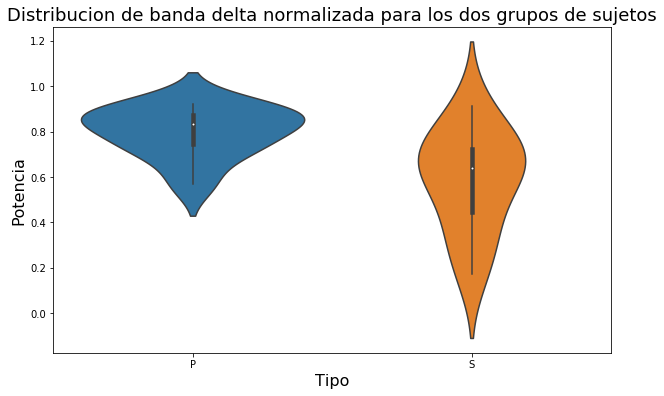

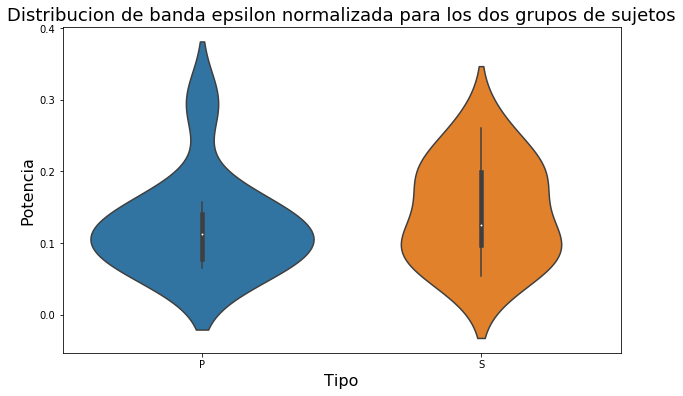

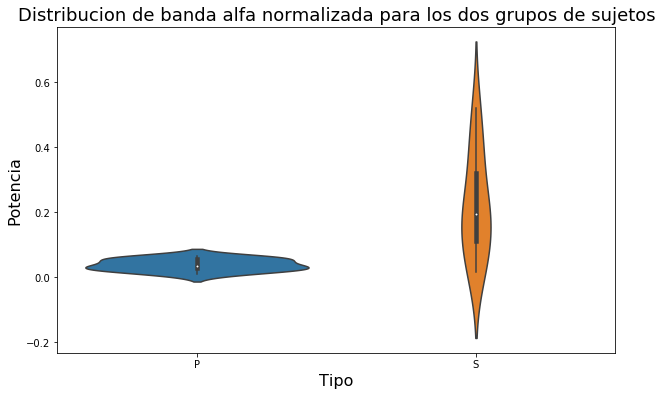

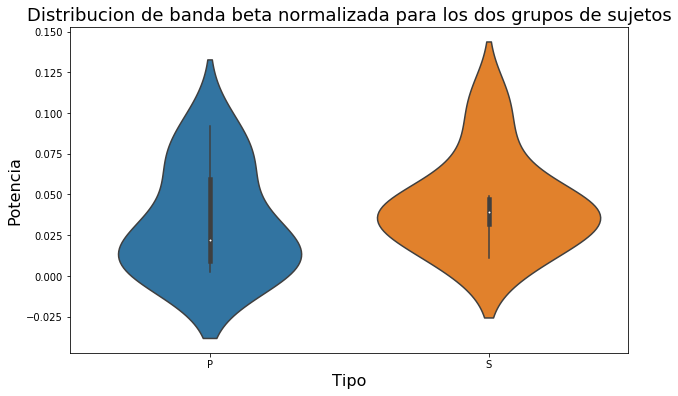

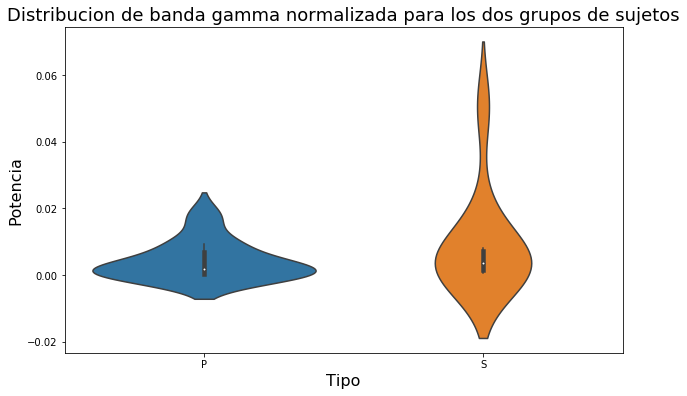

In [18]:
for banda in bandas:
    sns.violinplot(y=todos_tot[banda], x=todos_tot['Tipo'])
    plt.xlabel("Tipo", fontsize=16)
    plt.ylabel("Potencia", fontsize=16)
    plt.title("Distribucion de banda {} normalizada para los dos grupos de sujetos".format(banda), fontsize=18)
    plt.show()

#### Tests Estadisticos de las distribuciones de las bandas de frecuencia normalizadas
Repetimos los tests de rank-sum y de Bartlett con los valores normalizados:

In [19]:
normalizado_P = todos_tot[todos_tot.Tipo=='P'].iloc[:,0:-2]
normalizado_S = todos_tot[todos_tot.Tipo=='S'].iloc[:,0:-2]
print 'Ranksum (H0 medias iguales): \n'
for banda in bandas:
    print banda,'tiene p-value: ', ranksums(normalizado_P[banda], normalizado_S[banda]).pvalue
    
print '\nBartlett (H0 varianzas iguales): \n'
for banda in bandas:
    print banda,'tiene p-value: ', bartlett(normalizado_P[banda], normalizado_S[banda]).pvalue


Ranksum (H0 medias iguales): 

delta tiene p-value:  0.0155644113866
epsilon tiene p-value:  0.596701216729
alfa tiene p-value:  0.00650170237308
beta tiene p-value:  0.173617334425
gamma tiene p-value:  0.256839257958

Bartlett (H0 varianzas iguales): 

delta tiene p-value:  0.0458584644903
epsilon tiene p-value:  0.967432194656
alfa tiene p-value:  4.46963723362e-07
beta tiene p-value:  0.743934983794
gamma tiene p-value:  0.00703352699721


Del test Ranksum para los valores normalizados obtenemos que las medias de las bandas delta y alfa son distintas entre los grupos de pacientes. Para las bandas epsilon, beta y gamma no podemos rechazar la hipotesis nula (que tienen medias iguales).

A partir del test de Bartlett obtenemos que la varianza  de las bandas delta, alfa y gamma son distintas para los 2 grupos, y para epsilon y beta no se puede rechazar H0.


# Analisis de informacion

Para discretizar la senial usamos la regla de Freedman-Diaconis dada por N= ceil((max(x)-min(x))/2.Qx.n^(-1/3)). 
Buscaremos obtener una cantidad fija de bines por paciente para todas las muestras para poder compararlas entre ellas. Como requiere mucho poder de computo calcular el N en funcion de las muestras de todos los electrodos y epochs, lo haremos sobre 10000 muestras tomadas en forma aleatoria. Ademas, consideraremos el minimo como el 1-percentil y el maximo como el 99-percentil para que los outliers no nos aplien demasiado el rango.

In [124]:
def obtener_cant_bins(paciente_filename):
    arrayPromedio = np.array([], dtype=np.float64)
    
    paciente  = sio.loadmat(paciente_filename)['data'] 
    cant_epochs = paciente.shape[0]
    cant_electrodos = paciente.shape[1]
    cant_muestras = paciente.shape[2]
    for a in range(10000):
        epoch = randint(0,cant_epochs-1)
        electrodo = randint(0,cant_electrodos-1)
        arrayPromedio = np.concatenate([arrayPromedio, paciente[epoch][electrodo]])
    
    prim_cuartil = np.percentile(arrayPromedio, 25)
    terc_cuartil = np.percentile(arrayPromedio, 75)
    qx = terc_cuartil - prim_cuartil
    maximo = np.percentile(arrayPromedio, 97.5)
    minimo = np.percentile(arrayPromedio, 2.5)

    N = ceil((maximo - minimo)/(2*qx*(201**(-1/3))))
    return (N, maximo, minimo)

In [129]:
"""
    !!!!!!!!!!!!!!!!!!!!! NO EJECUTAR !!!!!!!!!!!!!!!!!!!!!

"""

filenames = ['dataset/P0'+str(i)+'.mat' for i in range(1,10)]+['dataset/P10.mat'] +\
            ['dataset/S0'+str(i)+'.mat' for i in range(1,10)]+['dataset/S10.mat']
# tablaCantBines = pd.DataFrame({"cant_bins": np.array([0.0]*20), "max": np.array([0.0]*20), "min": np.array([0.0]*20)}, index=filenames)

# for filename in tablaCantBines.index:
#     N, maximo, minimo = obtener_cant_bins(filename)
#     tablaCantBines.at[filename,'cant_bins'] = N
#     tablaCantBines.at[filename,'max'] =  maximo
#     tablaCantBines.at[filename,'min'] =  minimo

# tablaCantBines.to_pickle('bins.df')
tablaCantBines = pd.read_pickle('bins.df')
tablaCantBines

,cant_bins,max,min
dataset/P01.mat,442.0,0.000020,-0.000020
dataset/P02.mat,398.0,0.000025,-0.000025
dataset/P03.mat,433.0,0.000028,-0.000029
dataset/P04.mat,418.0,0.000020,-0.000020
dataset/P05.mat,397.0,0.000027,-0.000027
dataset/P06.mat,449.0,0.000024,-0.000023
dataset/P07.mat,395.0,0.000023,-0.000024
dataset/P08.mat,472.0,0.000015,-0.000015
dataset/P09.mat,398.0,0.000026,-0.000026
dataset/P10.mat,421.0,0.000020,-0.000020


In [130]:
def discretizar(muestras, paciente_filename):
    N = tablaCantBines.at[paciente_filename,'cant_bins']
    maximo = tablaCantBines.at[paciente_filename,'max']
    minimo = tablaCantBines.at[paciente_filename,'min']
    bin_size = (maximo-minimo)/N
    discretizacion = np.array([0] * len(muestras))
    for i in range(len(muestras)):
        if muestras[i] < minimo:
            discretizacion[i] = 0
        elif muestras[i] > maximo:
            discretizacion[i] = N
        else:
            discretizacion[i] = int((muestras[i] - minimo) / bin_size)
    return discretizacion

In [131]:
def divideN(elem):
    return np.float32(elem)/201


def get_entropia(muestras, N):
    buckets =np.histogram(muestras, bins=int(N), range=(0.0, N))[0]
    assert np.sum(buckets) == 201
    buckets = np.apply_along_axis(func1d=divideN, axis=0, arr=buckets)
    # con eso nos quedan las frecuencias
    h = 0
    for value in buckets:
        if value > 0:
            h += value * log(value)
    return -h

In [132]:
def obtener_entropia_media(paciente_filename):
    paciente  = sio.loadmat(paciente_filename)['data']
    cant_epochs = paciente.shape[0]
    cant_electrodos = paciente.shape[1]

    cantidad_mediciones = 10000
    suma_entropia = 0

    for a in range(cantidad_mediciones):
        epoch = randint(0,cant_epochs-1)
        electrodo = randint(0,cant_electrodos-1)
        disc = discretizar(paciente[epoch][electrodo], paciente_filename)
        suma_entropia += get_entropia(disc, tablaCantBines.at[paciente_filename,'cant_bins'])
    return suma_entropia/cantidad_mediciones

In [219]:
# for paciente_filename in tablaCantBines.index:
#     print paciente_filename
#     tablaCantBines.at[paciente_filename,"mean_entropy"] = obtener_entropia_media(paciente_filename)
# tablaCantBines.to_pickle('bins_con_entropia.df')
tablaCantBines = pd.read_pickle('bins_con_entropia.df')
tablaCantBines

,cant_bins,max,min,mean_entropy
dataset/P01.mat,442.0,0.000020,-0.000020,4.558436
dataset/P02.mat,398.0,0.000025,-0.000025,4.564015
dataset/P03.mat,433.0,0.000028,-0.000029,4.510575
dataset/P04.mat,418.0,0.000020,-0.000020,4.569392
dataset/P05.mat,397.0,0.000027,-0.000027,4.588546
dataset/P06.mat,449.0,0.000024,-0.000023,4.526505
dataset/P07.mat,395.0,0.000023,-0.000024,4.587590
dataset/P08.mat,472.0,0.000015,-0.000015,4.560409
dataset/P09.mat,398.0,0.000026,-0.000026,4.605861
dataset/P10.mat,421.0,0.000020,-0.000020,4.531637


In [220]:
tablaCantBines['Tipo']='S'
tablaCantBines[0:10]["Tipo"] = 'P'
tablaCantBines

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,cant_bins,max,min,mean_entropy,Tipo
dataset/P01.mat,442.0,0.000020,-0.000020,4.558436,P
dataset/P02.mat,398.0,0.000025,-0.000025,4.564015,P
dataset/P03.mat,433.0,0.000028,-0.000029,4.510575,P
dataset/P04.mat,418.0,0.000020,-0.000020,4.569392,P
dataset/P05.mat,397.0,0.000027,-0.000027,4.588546,P
dataset/P06.mat,449.0,0.000024,-0.000023,4.526505,P
dataset/P07.mat,395.0,0.000023,-0.000024,4.587590,P
dataset/P08.mat,472.0,0.000015,-0.000015,4.560409,P
dataset/P09.mat,398.0,0.000026,-0.000026,4.605861,P
dataset/P10.mat,421.0,0.000020,-0.000020,4.531637,P


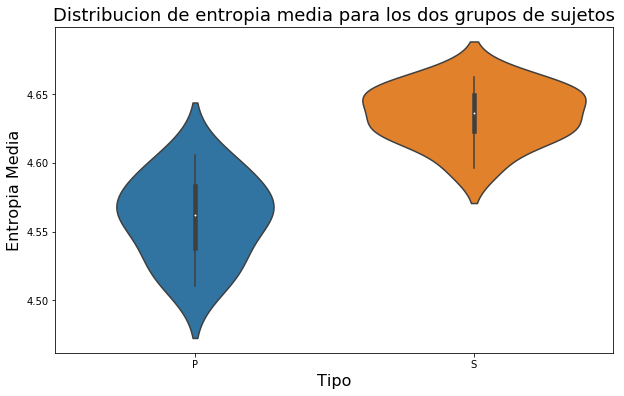

In [221]:
sns.violinplot(y=tablaCantBines["mean_entropy"], x=tablaCantBines['Tipo'])
plt.xlabel("Tipo", fontsize=16)
plt.ylabel("Entropia Media", fontsize=16)
plt.title("Distribucion de entropia media para los dos grupos de sujetos", fontsize=18)
plt.show()

In [222]:
meanEntropyP = tablaCantBines[tablaCantBines.Tipo == 'P']["mean_entropy"]
meanEntropyS = tablaCantBines[tablaCantBines.Tipo == 'S']["mean_entropy"]

print 'Ranksum (H0 medias iguales):'
print 'p-value: ', ranksums(meanEntropyP, meanEntropyS).pvalue, '\n'
    
print '\nBartlett (H0 varianzas iguales):'
print 'p-value: ', bartlett(meanEntropyP, meanEntropyS).pvalue


Ranksum (H0 medias iguales):
p-value:  0.000212182871223 


Bartlett (H0 varianzas iguales):
p-value:  0.25277567526


Para averiguar si la cantidad de bins usadas es apropiada para las mediciones inter-electrodo, decidimos medir la cantidad de bines ocupados para muestras con dos coordenadas. Este número, queremos que no sea ni muy pequeño, ni muy cercano a 201, que implicaría que no se repite una dupla de mediciones nunca. Para analizarlo, comparamos un electrodo tomado dos veces, contra dos electrodos con información similar, contra dos electrodos sin una fuerte relación aparente en el paciente P01.

In [223]:
def cantidad_de_rep_conj(muestras1, muestras2, N, paciente_filename):
    muestras = zip(muestras1,muestras2)
    contador = [0]*((int(N)+1)**2)
    for i in range(len(muestras1)):
        if (int((muestras1[i]*(N+1))+(muestras2[i]))>(int(N)+1)**2):
            print N+1, (int(N)+1)**2, muestras1[i], (int(muestras1[i]*(N+1)), (muestras2[i]))
        contador[int((muestras1[i]*(N+1))+(muestras2[i]))]+=1
    assert np.sum(contador) == 201
    contador2 = contador
    contador2 = sorted(contador2)
    n=0
    while(contador2[n]==0):
        n+=1
    contador2=contador2[n:]
    # con eso nos quedan las frecuencias en las que las mediciones caen en cada bucket
    return len (contador2)

In [224]:
data = "dataset/P01.mat"
paciente  = sio.loadmat(data)['data']
cant_epochs=paciente.shape[0]
cant_repes=70
suma1=0
suma2=0
suma3=0
for i in range(cant_repes):
    epoch1 = randint(0, cant_epochs-1)
    disc7 = discretizar(paciente[epoch1][8], data)
    disc8 = discretizar(paciente[epoch1][8], data)
    suma1+=cantidad_de_rep_conj(disc7, disc8, tablaCantBines.at[data,'cant_bins'], data)
    
    disc7 = discretizar(paciente[epoch1][131], data)
    disc8 = discretizar(paciente[epoch1][185], data)
    suma2+=cantidad_de_rep_conj(disc7, disc8, tablaCantBines.at[data,'cant_bins'], data)
    
    disc7 = discretizar(paciente[epoch1][8], data)
    disc8 = discretizar(paciente[epoch1][48], data)
    suma3+=cantidad_de_rep_conj(disc7, disc8, tablaCantBines.at[data,'cant_bins'], data)
suma1 = suma1/float(cant_repes)
suma2 = suma2/float(cant_repes)
suma3 = suma3/float(cant_repes)

print suma1
print suma2
print suma3

118.842857143
197.471428571
198.585714286


Como los resultados de los electrodos con aparente información común y los que no la parecen tener son muy similares, y muy cercanos a 201, decidimos reducir la cantidad de bines, favoreciendo las repeticiones.

In [225]:
for paciente_filename in tablaCantBines.index:
    tablaCantBines.at[paciente_filename,"nue_cant_bins"] = int(tablaCantBines.at[paciente_filename,'cant_bins']/8)
tablaCantBines

,cant_bins,max,min,mean_entropy,Tipo,nue_cant_bins
dataset/P01.mat,442.0,0.000020,-0.000020,4.558436,P,55.0
dataset/P02.mat,398.0,0.000025,-0.000025,4.564015,P,49.0
dataset/P03.mat,433.0,0.000028,-0.000029,4.510575,P,54.0
dataset/P04.mat,418.0,0.000020,-0.000020,4.569392,P,52.0
dataset/P05.mat,397.0,0.000027,-0.000027,4.588546,P,49.0
dataset/P06.mat,449.0,0.000024,-0.000023,4.526505,P,56.0
dataset/P07.mat,395.0,0.000023,-0.000024,4.587590,P,49.0
dataset/P08.mat,472.0,0.000015,-0.000015,4.560409,P,59.0
dataset/P09.mat,398.0,0.000026,-0.000026,4.605861,P,49.0
dataset/P10.mat,421.0,0.000020,-0.000020,4.531637,P,52.0


Probamos nuevamente con estos nuevos valores de bins.

In [226]:
def nue_discretizar(muestras, paciente_filename):
    N = tablaCantBines.at[paciente_filename,'nue_cant_bins']
    maximo = tablaCantBines.at[paciente_filename,'max']
    minimo = tablaCantBines.at[paciente_filename,'min']
    bin_size = (maximo-minimo)/N
    discretizacion = np.array([0] * len(muestras))
    for i in range(len(muestras)):
        if muestras[i] < minimo:
            discretizacion[i] = 0
        elif muestras[i] > maximo:
            discretizacion[i] = N
        else:
            discretizacion[i] = int((muestras[i] - minimo) / bin_size)
    return discretizacion

In [227]:
data = "dataset/P01.mat"
paciente  = sio.loadmat(data)['data']
cant_epochs=paciente.shape[0]
cant_repes=70
suma1=0
suma2=0
suma3=0
for i in range(cant_repes):
    epoch1 = randint(0, cant_epochs-1)
    disc7 = nue_discretizar(paciente[epoch1][8], data)
    disc8 = nue_discretizar(paciente[epoch1][8], data)
    suma1+=cantidad_de_rep_conj(disc7, disc8, tablaCantBines.at[data,'nue_cant_bins'], data)
    
    disc7 = nue_discretizar(paciente[epoch1][131], data)
    disc8 = nue_discretizar(paciente[epoch1][185], data)
    suma2+=cantidad_de_rep_conj(disc7, disc8, tablaCantBines.at[data,'nue_cant_bins'], data)
    
    disc7 = nue_discretizar(paciente[epoch1][8], data)
    disc8 = nue_discretizar(paciente[epoch1][48], data)
    suma3+=cantidad_de_rep_conj(disc7, disc8, tablaCantBines.at[data,'nue_cant_bins'], data)
suma1 = suma1/float(cant_repes)
suma2 = suma2/float(cant_repes)
suma3 = suma3/float(cant_repes)

print suma1
print suma2
print suma3

28.7142857143
116.9
152.028571429


In [228]:
def get_entropia_conjunta(muestras1, muestras2, N, paciente_filename):
    muestras = zip(muestras1,muestras2)
    contador = [0]*((int(N)+1)**2)
    for i in range(len(muestras1)):
        contador[int((muestras1[i]*(N+1))+(muestras2[i]))]+=1
    assert np.sum(contador) == 201
    contador = map(lambda x : x/201.0, contador)
    # con eso nos quedan las frecuencias en las que las mediciones caen en cada bucket
    h = 0
    for value in contador:
        if value > 0:
            h += value * log(value)
    return -h

In [229]:
def get_informacion_mutua(muestras1, muestras2, N, paciente_filename):
    muestras = zip(muestras1,muestras2)
    contador1 = [0]*(int(N)+1)
    contador2 = [0]*(int(N)+1)
    contador = [0]*((int(N)+1)**2)
    for i in range(len(muestras1)):
        contador1[muestras1[i]]+=1
    assert np.sum(contador1) == 201
    
    for i in range(len(muestras2)):
        contador2[muestras2[i]]+=1
    assert np.sum(contador2) == 201
    
    for i in range(len(muestras1)):
        contador[int((muestras1[i]*(N+1))+(muestras2[i]))]+=1
    assert np.sum(contador) == 201
    
    contador1 = map(lambda x : x/201.0, contador1)
    contador2 = map(lambda x : x/201.0, contador2)
    contador = map(lambda x : x/201.0, contador)
    # con eso nos quedan las frecuencias en las que las mediciones caen en cada bucket
    
    h = 0
    for iterator in range(len(contador)):
        if contador[iterator] > 0:
            iterator1 = int(iterator/(int(N+1)))
            iterator2 = int(iterator-(iterator1*(N+1)))
            h += contador[iterator] * log(contador[iterator]/((contador1[iterator1])*(contador2[iterator2])))
    return h

In [230]:
def obtener_informacion_mutua_media(arraydeelectrodos, paciente_filename):
    paciente  = sio.loadmat(paciente_filename)['data']
    cant_epochs = paciente.shape[0]

    cant_repeticiones = 60
    suma_informacion = 0   
    for electrodo1 in range(0, len(arraydeelectrodos)-1):
        for electrodo2 in range(electrodo1+1, len(arraydeelectrodos)):
            for a in range(cant_repeticiones):
                epoch = randint(0, cant_epochs-1)
                disc1 = nue_discretizar(paciente[epoch][arraydeelectrodos[electrodo1]], paciente_filename)
                disc2 = nue_discretizar(paciente[epoch][arraydeelectrodos[electrodo2]], paciente_filename)
                suma_informacion += get_informacion_mutua(disc1, disc2, tablaCantBines.at[paciente_filename,'nue_cant_bins'], paciente_filename)
    return suma_informacion/(cant_repeticiones*((len(arraydeelectrodos)*(len(arraydeelectrodos)-1))/2.0))

In [231]:
def obtener_entropia_conjunta_media(arraydeelectrodos, paciente_filename):
    paciente  = sio.loadmat(paciente_filename)['data']
    cant_epochs = paciente.shape[0]

    cant_repeticiones = 100
    suma_entropia = 0   
    for electrodo1 in range(0, len(arraydeelectrodos)-1):
        for electrodo2 in range(electrodo1+1, len(arraydeelectrodos)):
            for a in range(cant_repeticiones):
                epoch = randint(0, cant_epochs-1)
                disc1 = nue_discretizar(paciente[epoch][arraydeelectrodos[electrodo1]], paciente_filename)
                disc2 = nue_discretizar(paciente[epoch][arraydeelectrodos[electrodo2]], paciente_filename)
                suma_entropia += get_entropia_conjunta(disc1, disc2, tablaCantBines.at[paciente_filename,'nue_cant_bins'], paciente_filename)
    return suma_entropia/(cant_repeticiones*((len(arraydeelectrodos)*(len(arraydeelectrodos)-1))/2.0))

In [232]:
# checkeo1 = obtener_informacion_mutua_media([131,185],"dataset/S05.mat")
# checkeo2 = obtener_informacion_mutua_media([8,19],"dataset/S05.mat")
# checkeo3 = obtener_informacion_mutua_media([8,8],"dataset/S05.mat")

# print checkeo1, checkeo2, checkeo3

In [238]:
# for paciente_filename in tablaCantBines.index:
#     tablaCantBines.at[paciente_filename,"mean_mutual_information_131_185"] = obtener_informacion_mutua_media([131,185],paciente_filename)
#     tablaCantBines.at[paciente_filename,"mean_mutual_information_45_122"] = obtener_informacion_mutua_media([45,122],paciente_filename)
#     tablaCantBines.at[paciente_filename,"mean_mutual_information_90_81"] = obtener_informacion_mutua_media([90,81],paciente_filename)
#     tablaCantBines.at[paciente_filename,"mean_mutual_information_156_209"] = obtener_informacion_mutua_media([156,209],paciente_filename)
#     tablaCantBines.at[paciente_filename,"mean_mutual_information_156_136"] = obtener_informacion_mutua_media([156,136],paciente_filename)
#     tablaCantBines.at[paciente_filename,"mean_mutual_information_9_36"] = obtener_informacion_mutua_media([9,36],paciente_filename)
tablaCantBines.to_pickle('binterelectrodo.df')
# tablaCantBines = pd.read_pickle('bins_interelectrodo.df')

In [239]:
tablaCantBines

,cant_bins,max,min,mean_entropy,Tipo,nue_cant_bins,mean_mutual_information_131_185,mean_mutual_information_45_122,mean_mutual_information_90_81,mean_mutual_information_156_209,mean_mutual_information_156_136,mean_mutual_information_9_36
dataset/P01.mat,442.0,0.000020,-0.000020,4.558436,P,55.0,1.531065,1.514356,1.778669,1.333055,1.535272,1.448284
dataset/P02.mat,398.0,0.000025,-0.000025,4.564015,P,49.0,1.416798,1.457300,1.791579,1.318967,1.318782,1.572090
dataset/P03.mat,433.0,0.000028,-0.000029,4.510575,P,54.0,1.732330,1.316486,1.523797,1.346866,1.284638,1.586158
dataset/P04.mat,418.0,0.000020,-0.000020,4.569392,P,52.0,1.681350,1.354685,1.500729,1.382890,1.417784,1.465964
dataset/P05.mat,397.0,0.000027,-0.000027,4.588546,P,49.0,1.551744,1.257219,1.755250,1.493600,1.373848,1.446486
dataset/P06.mat,449.0,0.000024,-0.000023,4.526505,P,56.0,1.643435,1.358725,1.493706,1.323842,1.342308,1.595688
dataset/P07.mat,395.0,0.000023,-0.000024,4.587590,P,49.0,1.517399,1.499848,1.896935,1.327015,1.499547,1.549759
dataset/P08.mat,472.0,0.000015,-0.000015,4.560409,P,59.0,1.505311,1.503643,1.760904,1.373113,1.746697,1.689083
dataset/P09.mat,398.0,0.000026,-0.000026,4.605861,P,49.0,1.279827,1.457536,2.061719,1.625046,1.500728,1.524412
dataset/P10.mat,421.0,0.000020,-0.000020,4.531637,P,52.0,1.666567,1.344945,1.569334,1.413503,1.562162,1.423292


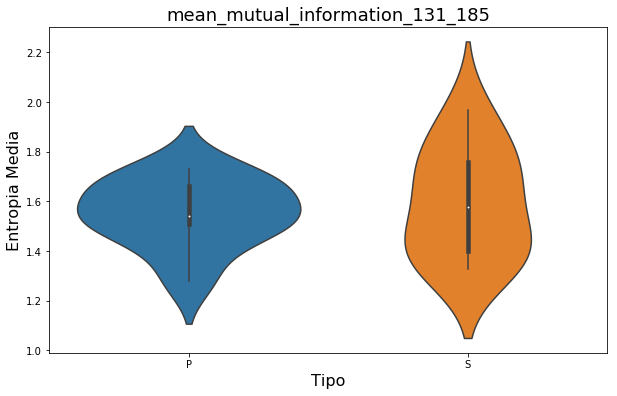

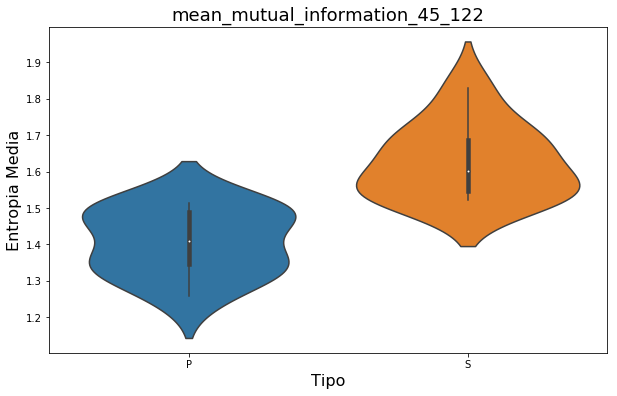

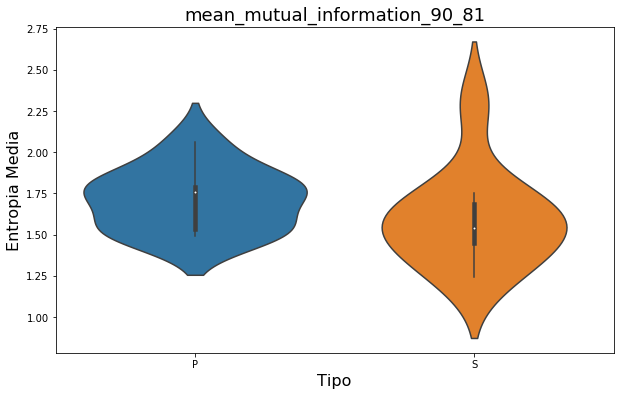

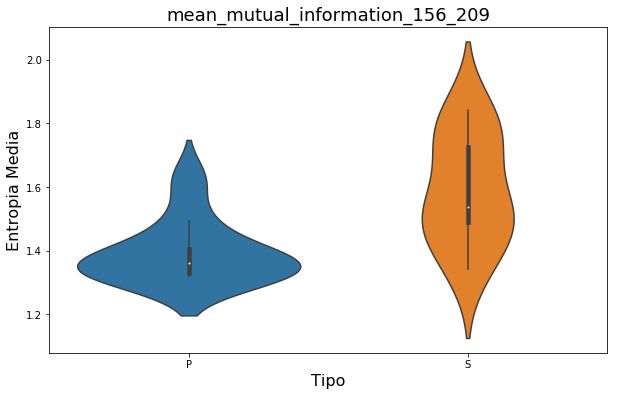

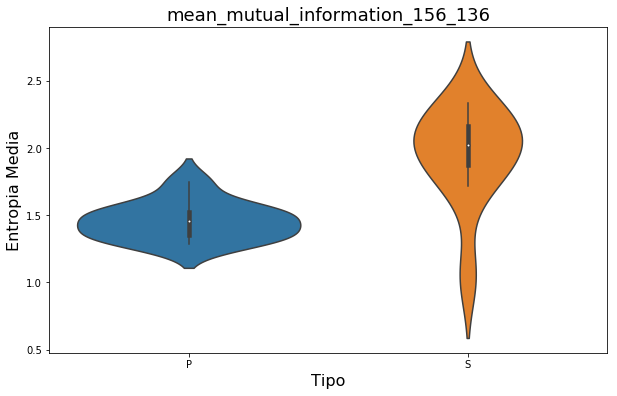

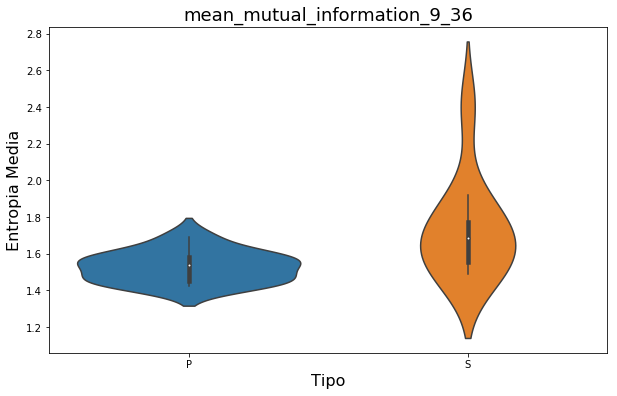

In [235]:
medias = ['mean_mutual_information_131_185', 'mean_mutual_information_45_122', 'mean_mutual_information_90_81', \
          'mean_mutual_information_156_209', 'mean_mutual_information_156_136', 'mean_mutual_information_9_36']
for media in medias:
    sns.violinplot(y=tablaCantBines[media], x=tablaCantBines['Tipo'])
    plt.xlabel("Tipo", fontsize=16)
    plt.ylabel("Entropia Media", fontsize=16)
    plt.title(media, fontsize=18)
    plt.show()